<a href="https://colab.research.google.com/github/lsoica/blog/blob/main/assets/rnn-from-scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RNN from scratch

RNNs acts as sequence processors. They take a sequence of inputs, and produce a sequence of outputs. The input sequence length is variable, it can take a sequence of 7 steps or 7000 steps, doesn't matter.

We have:
 - Input layer: one weights matrix and one bias vector
 - Hidden layer: one weights matrix and one bias vector
 - Output layer: one weights matrix and one bias vector

![RNN architecture](./rnn-from-scratch.png)

 For each input X, we have:
 - Input layer: $XI = X \times W_i + b_i$
 - Hidden layer: $XH(t_n) = \text{activation}(XH(t_{n-1}) + XI)$
 - Output layer: $XO = XH(t_n) \times W_o + b_o$



![RNN operations](./rnn_operations.png)

![RNN operations](./rnn-matrix.png)


 
 - Input has 3 features so its shape is: (1, 3)
 - Input layer has 5 neurons, so its weights shape is: (3, 5). XI has shape (1, 5)
 - Hidden layer has 5 neurons, so its weights shape is: (5, 5). XH has shape (1, 5) as it XH_previous (1,5) @ H_weights (5,5) = (1,5). XI+XH has shape (1, 5). The resulting XH has shape (1, 5).
 - Output layer has 1 neuron, so its weights shape is: (5, 1). XO has shape (1, 1)

## Install required packages

In [ ]:
!pip install torch matplotlib


## Download the data

In [2]:
!curl https://raw.githubusercontent.com/VikParuchuri/zero_to_gpt/refs/heads/master/data/clean_weather.csv -o clean_weather.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  396k  100  396k    0     0   727k      0 --:--:-- --:--:-- --:--:--  726k


## Import libraries

In [4]:
import pandas as pd
import numpy as np

## Read the data

Each row is a day, with columns for each weather variable. We have tmax, tmin, rain. tmax_tomorrow is the target, what we're trying to predict.

ffill fills in missing values with the last known value.

In [5]:


# Read in our data, and fill missing values
data = pd.read_csv("./clean_weather.csv", index_col=0)
data = data.ffill()

data

,tmax,tmin,rain,tmax_tomorrow
1970-01-01,60.0,35.0,0.0,52.0
1970-01-02,52.0,39.0,0.0,52.0
1970-01-03,52.0,35.0,0.0,53.0
1970-01-04,53.0,36.0,0.0,52.0
1970-01-05,52.0,35.0,0.0,50.0
...,...,...,...,...
2022-11-22,62.0,35.0,0.0,67.0
2022-11-23,67.0,38.0,0.0,66.0
2022-11-24,66.0,41.0,0.0,70.0
2022-11-25,70.0,39.0,0.0,62.0


The most common activation function for RNNs is the tanh function:

$$
\text{tanh}(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}
$$

The derivative of the tanh function is:

$$
\text{tanh}'(x) = 1 - \text{tanh}(x)^2
$$

Let's graph the tanh function and its derivative:

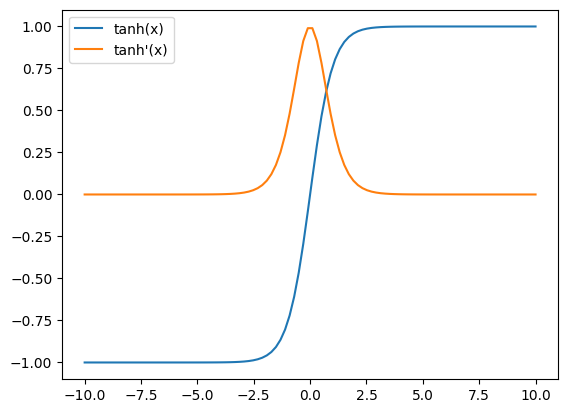

In [6]:
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, 100)
y = np.tanh(x)
dy = 1 - y**2

plt.plot(x, y, label='tanh(x)')
plt.plot(x, dy, label="tanh'(x)")
plt.legend()
plt.show()  

## Full Implementation


In [15]:
from sklearn.preprocessing import StandardScaler
import math

# Define predictors and target
PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Scale our data to have mean 0
scaler = StandardScaler()
data[PREDICTORS] = scaler.fit_transform(data[PREDICTORS])

# Split into train, valid, test sets: 70% train, 15% valid, 15% test
np.random.seed(0)
split_data = np.split(data, [int(.7*len(data)), int(.85*len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()] for d in split_data]

/Users/LSoica/work/AI/blog/.venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [16]:
def init_params(layer_conf):
    layers = []
    for i in range(1, len(layer_conf)):
        np.random.seed(0)
        k = 1/math.sqrt(layer_conf[i]["hidden"])
        i_weight = np.random.rand(layer_conf[i-1]["units"], layer_conf[i]["hidden"]) * 2 * k - k

        h_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["hidden"]) * 2 * k - k
        h_bias = np.random.rand(1, layer_conf[i]["hidden"]) * 2 * k - k

        o_weight = np.random.rand(layer_conf[i]["hidden"], layer_conf[i]["output"]) * 2 * k - k
        o_bias = np.random.rand(1, layer_conf[i]["output"]) * 2 * k - k

        layers.append(
            [i_weight, h_weight, h_bias, o_weight, o_bias]
        )
    return layers

### forward pass

In [9]:
# using mean squared error as loss function
def mse(actual, predicted):
    return np.mean((actual-predicted)**2)

# mse gradient is the difference between actual and predicted. It the negative of the mse derivative
def mse_grad(actual, predicted):
    return (predicted - actual)

In [23]:
# we run through the network a sequence of 20 inputs. start with hidden state and output state as 0
def forward(x, layers):
    hiddens = []
    outputs = []
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = np.zeros((x.shape[0], i_weight.shape[1]))
        output = np.zeros((x.shape[0], o_weight.shape[1]))
        for j in range(x.shape[0]):
            input_x = x[j,:][np.newaxis,:] @ i_weight
            hidden_x = input_x + hidden[max(j-1,0),:][np.newaxis,:] @ h_weight + h_bias
            # Activation.  tanh avoids outputs getting larger and larger.
            hidden_x = np.tanh(hidden_x)
            # Store hidden for use in backprop
            hidden[j,:] = hidden_x

            # Output layer
            output_x = hidden_x @ o_weight + o_bias
            output[j,:] = output_x
        # Store hidden and output for use in backprop
        hiddens.append(hidden)
        outputs.append(output)
    return hiddens, outputs[-1]

### Backward pass

NN backpropagation function is:

$$
\text{NN} = tanh((Input @ I_w + I_b) + (XH(t_n-1) @ H_w + H_b)) @ O_w + O_b
$$




![Backward pass](./rnn-backpropagation.png)

In [24]:
def backward(layers, x, lr, grad, hiddens):
    for i in range(len(layers)):
        i_weight, h_weight, h_bias, o_weight, o_bias = layers[i]
        hidden = hiddens[i]
        next_h_grad = None
        i_weight_grad, h_weight_grad, h_bias_grad, o_weight_grad, o_bias_grad = [0] * 5

        for j in range(x.shape[0] - 1, -1, -1):
            # Add newaxis in the first dimension
            out_grad = grad[j,:][np.newaxis, :]

            # Output updates
            # np.newaxis creates a size 1 axis, in this case transposing matrix
            o_weight_grad += hidden[j,:][:, np.newaxis] @ out_grad
            o_bias_grad += out_grad

            # Propagate gradient to hidden unit
            h_grad = out_grad @ o_weight.T

            if j < x.shape[0] - 1:
                # Then we multiply the gradient by the hidden weights to pull gradient from next hidden state to current hidden state
                hh_grad = next_h_grad @ h_weight.T
                # Add the gradients together to combine output contribution and hidden contribution
                h_grad += hh_grad

            # Pull the gradient across the current hidden nonlinearity
            # derivative of tanh is 1 - tanh(x) ** 2
            # So we take the output of tanh (next hidden state), and plug in
            tanh_deriv = 1 - hidden[j][np.newaxis,:] ** 2

            # next_h_grad @ np.diag(tanh_deriv_next) multiplies each element of next_h_grad by the deriv
            # Effect is to pull value across nonlinearity
            h_grad = np.multiply(h_grad, tanh_deriv)

            # Store to compute h grad for previous sequence position
            next_h_grad = h_grad.copy()

            # If we're not at the very beginning
            if j > 0:
                # Multiply input from previous layer by post-nonlinearity grad at current layer
                h_weight_grad += hidden[j-1][:, np.newaxis] @ h_grad
                h_bias_grad += h_grad

            i_weight_grad += x[j,:][:,np.newaxis] @ h_grad

        # Normalize lr by number of sequence elements
        lr = lr / x.shape[0]
        i_weight -= i_weight_grad * lr
        h_weight -= h_weight_grad * lr
        h_bias -= h_bias_grad * lr
        o_weight -= o_weight_grad * lr
        o_bias -= o_bias_grad * lr
        layers[i] = [i_weight, h_weight, h_bias, o_weight, o_bias]
    return layers

### Training

In [52]:
epochs = 21
lr = 0.0001
sequence_len = 13

layer_conf = [
    {"type":"input", "units": 3},
    {"type": "rnn", "hidden": 5, "output": 1}
]
layers = init_params(layer_conf)

for epoch in range(epochs):
    epoch_loss = 0
    for j in range(train_x.shape[0] - sequence_len):
        seq_x = train_x[j:(j+sequence_len),]
        seq_y = train_y[j:(j+sequence_len),]
        hiddens, outputs = forward(seq_x, layers)
        grad = mse_grad(seq_y, outputs)
        params = backward(layers, seq_x, lr, grad, hiddens)
        epoch_loss += mse(seq_y, outputs)

    if epoch % 2 == 0:
        valid_loss = 0
        for j in range(valid_x.shape[0] - sequence_len):
            seq_x = valid_x[j:(j+sequence_len),]
            seq_y = valid_y[j:(j+sequence_len),]
            _, outputs = forward(seq_x, layers)
            valid_loss += mse(seq_y, outputs)

        print(f"Epoch: {epoch} train loss {epoch_loss / len(train_x)} valid loss {valid_loss / len(valid_x)}")
        history = np.array([[60.0, 38.0, 0.0], [65.0, 39.0, 0.0], [66.0, 36.0, 0.0], [64.0, 38.0, 0.0], [63.0, 38.0, 0.0], [62.0, 42.0, 0.0], [61.0, 37.0, 0.0], [60.0, 36.0, 0.0], [62.0, 35.0, 0.0], [67.0, 38.0, 0.0], [66.0, 41.0, 0.0], [70.0, 39.0, 0.0], [62.0, 41.0, 0.0]])

        _, predictions = forward(history, layers)
        print(f"Prediction: {predictions[-1][0]} vs actual: 64")



Epoch: 0 train loss 519.6897645583397 valid loss 72.75332393001642
Prediction: 66.62851833139118 vs actual: 64
Epoch: 2 train loss 36.42163982733737 valid loss 34.5787728792624
Prediction: 77.24747225976233 vs actual: 64
Epoch: 4 train loss 27.382911331350147 valid loss 29.880311580291163
Prediction: 83.61372429665458 vs actual: 64
Epoch: 6 train loss 23.86992827107105 valid loss 29.5155110803209
Prediction: 87.15185060463273 vs actual: 64
Epoch: 8 train loss 22.097282189052727 valid loss 28.867248732991
Prediction: 89.56176331634961 vs actual: 64
Epoch: 10 train loss 21.19754778288571 valid loss 28.319600958096984
Prediction: 90.9757596641493 vs actual: 64
Epoch: 12 train loss 20.80703158428252 valid loss 28.007075069070954
Prediction: 91.67585229723386 vs actual: 64
Epoch: 14 train loss 20.624720897995743 valid loss 27.795451578250965
Prediction: 91.98200920596689 vs actual: 64
Epoch: 16 train loss 20.534074732042967 valid loss 27.6354128815431
Prediction: 91.98152140187526 vs actual

In [53]:
# 2022-11-14,60.0,38.0,0.0,65.0
# 2022-11-15,65.0,39.0,0.0,66.0
# 2022-11-16,66.0,36.0,0.0,64.0
# 2022-11-17,64.0,38.0,0.0,63.0
# 2022-11-18,63.0,38.0,0.0,62.0
# 2022-11-19,62.0,42.0,0.0,61.0
# 2022-11-20,61.0,37.0,0.0,60.0
# 2022-11-21,60.0,36.0,0.0,62.0
# 2022-11-22,62.0,35.0,0.0,67.0
# 2022-11-23,67.0,38.0,0.0,66.0
# 2022-11-24,66.0,41.0,0.0,70.0
# 2022-11-25,70.0,39.0,0.0,62.0
# 2022-11-26,62.0,41.0,0.0,64.0

history = np.array([[60.0, 38.0, 0.0], [65.0, 39.0, 0.0], [66.0, 36.0, 0.0], [64.0, 38.0, 0.0], [63.0, 38.0, 0.0], [62.0, 42.0, 0.0], [61.0, 37.0, 0.0], [60.0, 36.0, 0.0], [62.0, 35.0, 0.0], [67.0, 38.0, 0.0], [66.0, 41.0, 0.0], [70.0, 39.0, 0.0], [62.0, 41.0, 0.0]])

_, predictions = forward(history, layers)
# print all predictions
print(predictions)
# print last prediction
print(predictions[-1][0])


[[40.10723141]
 [41.53303368]
 [42.36439085]
 [42.42101967]
 [43.48365448]
 [44.49978194]
 [48.4633702 ]
 [53.26467986]
 [58.1371818 ]
 [58.88674495]
 [59.46713998]
 [59.24355687]
 [62.98421949]]
62.98421948718461


## References
- https://github.com/VikParuchuri/zero_to_gpt/blob/master/explanations/rnn.ipynb
- https://www.youtube.com/watch?v=4wuIOcD1LLI